## Análise dos dados disponibilizados pela PRF sobre os acidentes nas rodovias federais em 2020. 
Os arquivos de dados encontram-se em data.zip.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import findspark
findspark.init()
import pyspark
import pyspark.sql.functions as F

In [2]:
#set matplotlib options
#plt.rc('text', usetex=True)
plt.rc('text', color='0.2')
plt.rc('font', family='serif', size=18)
plt.rc('axes', linewidth=1.5, edgecolor='0.2', labelsize=18)
plt.rc('xtick', top=True, labelsize=16, color='0.2', direction='in')
plt.rc('xtick.major', width=1.5)
plt.rc('xtick.minor', visible=False)
plt.rc('ytick', right=True, labelsize=16, color='0.2', direction='in')
plt.rc('ytick.major', width=1.5)
plt.rc('ytick.minor', visible=False)
plt.rc('legend', fontsize=18, handlelength=0.5, handletextpad=0.4)
plt.rc('grid', color='grey')
#font = {'color':'k', 'usetex':True}
# seaborn style
plt.style.use('seaborn-deep')

In [3]:
# Start SparkSession.
from pyspark.sql import SparkSession
spark = (SparkSession
         .builder
         .appName("BR_Traffic")
         .getOrCreate())

In [4]:
# Define schema.
schema = "`id` INT, "
schema += "`data_inversa` STRING, "
schema += "`dia_semana` STRING, "
schema += "`horario` STRING, "
schema += "`uf` STRING, "
schema += "`br` INT, "
schema += "`km` STRING, "
schema += "`municipio` STRING, "
schema += "`causa_acidente` STRING, "
schema += "`tipo_acidente` STRING, "
schema += "`classificacao_acidente` STRING, "
schema += "`fase_dia` STRING, "
schema += "`sentido_via` STRING, " 
schema += "`condicao_metereologica` STRING, "
schema += "`tipo_pista` STRING, " 
schema += "`tracado_via` STRING, " 
schema += "`uso_solo` STRING, "
schema += "`pessoas` INT, "
schema += "`mortos` INT, "
schema += "`feridos_leves` INT, " 
schema += "`feridos_graves` INT, "
schema += "`ilesos` INT, "
schema += "`ignorados` INT, "
schema += "`feridos` INT, "
schema += "`veiculos` INT, "
schema += "`latitude` STRING, " 
schema += "`longitude` STRING, "
schema += "`regional` STRING, "
schema += "`delegacia` STRING, "
schema += "`uop` STRING"

In [5]:
# Read data file.
df = (spark.read.format("csv")
      .schema(schema)
      .options(header="True", sep=';', encoding="ISO-8859-1")
      .load("datatran2020.csv"))

# Concatenate 'data_inversa' and 'horario' and convert to time stamp.
df = df.withColumn("data_horario", F.concat(df.data_inversa, F.lit(" "), df.horario))
df = (df.withColumn("data_horario", F.to_timestamp(df.data_horario, "yyyy-MM-dd HH:mm:ss"))
      .drop("data_inversa", "horario"))

# Convert to float. Spark read cannot handle ',' for decimals.
for tag in ["km", "latitude", "longitude"]:
    df = df.withColumn(tag, F.regexp_replace(tag, ',', '.'))
    df = df.withColumn(tag, df[tag].cast("float"))

### Qual o total de acidentes, feridos graves e mortos nas rodovias federais em 2020?

In [6]:
row_agg = (df.select("mortos", "feridos_graves", "id")
          .agg(F.sum("mortos"), F.sum("feridos_graves"), F.count("id"))
          .head())

print("Total de %d feridos graves e %d mortos em %d acidentes nas rodovias federais em 2020."
      % (row_agg[1], row_agg[0], row_agg[2]))

Total de 17056 feridos graves e 5287 mortos em 63446 acidentes nas rodovias federais em 2020.


### Os 10 acidentes mais violentos nas rodovias federais em 2020.

In [7]:
(df.select("br", "uf", "km", "mortos", "feridos_graves", "causa_acidente")
 .sort(df.mortos.desc(), df.feridos_graves.desc())
 .show(10, truncate=False))

+---+---+-----+------+--------------+-------------------------------------------------+
|br |uf |km   |mortos|feridos_graves|causa_acidente                                   |
+---+---+-----+------+--------------+-------------------------------------------------+
|381|MG |350.0|13    |19            |Defeito Mecânico no Veículo                      |
|365|MG |373.5|12    |1             |Objeto estático sobre o leito carroçável         |
|365|MG |151.8|11    |17            |Condutor Dormindo                                |
|262|MG |153.0|8     |1             |Velocidade Incompatível                          |
|267|MS |239.4|8     |0             |Desobediência às normas de trânsito pelo condutor|
|277|PR |76.0 |7     |4             |Restrição de Visibilidade                        |
|116|BA |538.4|7     |0             |Ultrapassagem Indevida                           |
|280|SC |224.8|6     |0             |Falta de Atenção à Condução                      |
|20 |GO |109.5|5     |2         

### Qual a distribuição de acidentes durante o dia?

In [8]:
df_dia = (df.select("id", "data_horario", "feridos_leves", "feridos_graves", "mortos")
           .withColumn("time_slot", F.hour("data_horario")))
df_dia = (df_dia.groupBy("time_slot")
          .agg(F.count("id"), 
               F.sum("feridos_leves"), 
               F.sum("feridos_graves"), 
               F.sum("mortos"))
           .sort("time_slot")
           .toPandas())

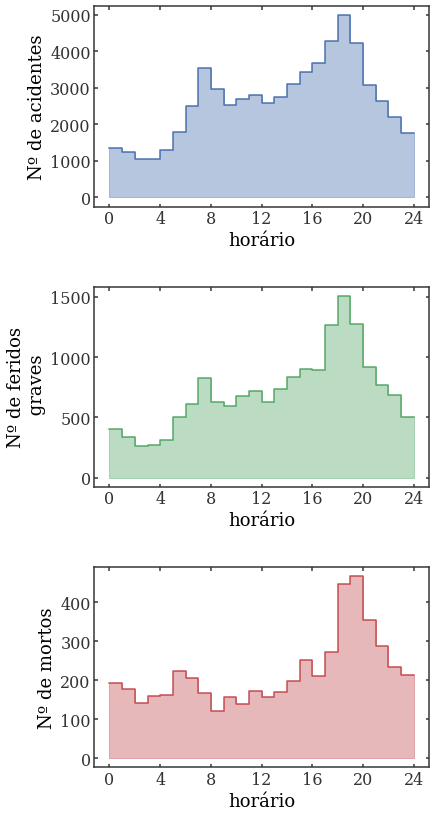

In [25]:
x = np.append(df_dia.loc[:, "time_slot"].values, [24])
fig, ax = plt.subplots(3, 1, figsize=(6,14))
y = df_dia.iloc[:, 1:].values
y = np.append(y, y[-1:, :], axis=0)

for axi, i, color in zip(ax, [0, 2, 3], ["C0", "C1", "C2"]):
    axi.step(x, y[:, i], where="post", color=color)
    axi.fill_between(x, y[:, i], step="post", alpha=0.4, color=color)

ax[0].set_ylabel("Nº de acidentes")
ax[1].set_ylabel("Nº de feridos\n graves")
ax[2].set_ylabel("Nº de mortos")

for axi in ax:
    axi.set_xlabel("horário")
    axi.set_xticks(np.arange(0, 25, 4))
    
fig.subplots_adjust(hspace=0.4)

### Qual a distribuição de acidentes durante o ano?

In [11]:
# Group by month.
df_ano = (df.select("id", "data_horario", "feridos_leves", "feridos_graves", "mortos")
          .withColumn("time_slot", F.month("data_horario")))
df_ano = (df_ano.groupBy("time_slot")
          .agg(F.count("id"), 
               F.sum("feridos_leves"), 
               F.sum("feridos_graves"), 
               F.sum("mortos"))
          .sort("time_slot")
          .toPandas())

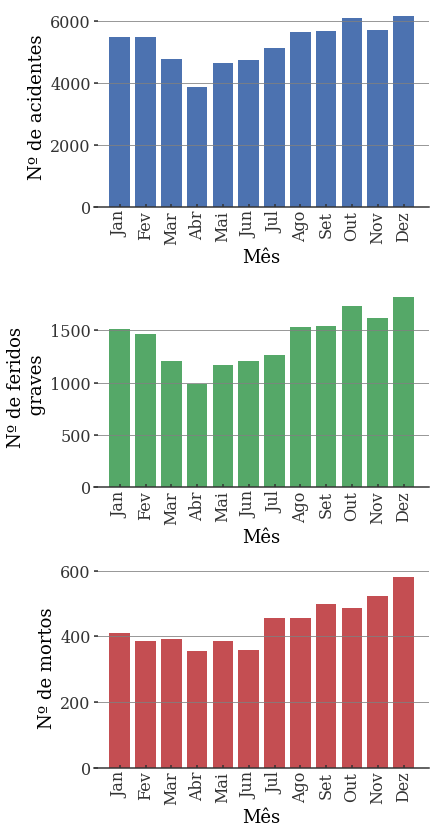

In [12]:
x = df_ano.loc[:, "time_slot"].values
width = 0.8
fig, ax = plt.subplots(3, 1, figsize=(6,14))
y = df_ano.iloc[:, 1:].values

ax[0].bar(x - width/2, y[:, 0], width, color="C0")
ax[1].bar(x - width/2, y[:, 2], width, color="C1")
ax[2].bar(x - width/2, y[:, 3], width, color="C2")

labels = ["Nº de acidentes", "Nº de feridos\n graves", "Nº de mortos"]
for i, axi in enumerate(ax):
    axi.set_xlabel("Mês")
    axi.set_ylabel(labels[i])
    
    axi.set_xticks(x - width/2)
    axi.set_xticklabels(["Jan", "Fev", "Mar", "Abr", "Mai", "Jun", "Jul", "Ago", "Set",
                         "Out", "Nov", "Dez"], rotation=90)
    axi.yaxis.set_ticks_position('left')
    axi.xaxis.set_ticks_position('bottom')
    axi.grid(axis='y')
    for tag in ["right", "left", "top"]:
        axi.spines[tag].set_visible(False)

    
fig.subplots_adjust(hspace=0.4)

### Vamos analisar o caso específico da BR-381. Qual a distribuição dos acidentes na BR-381?

In [13]:
# Filter data on BR-381
df381 = df.where(F.col("br") == 381)
# Correct the 'km' column.
# For some reason the 'km' start counting from zero once we reach the state of São Paulo.
km_max = df381.agg(F.max("km")).head()[0]
df381 = df381.withColumn("km", F.when(F.col("uf") == "SP", F.col("km") + km_max)
                         .otherwise(F.col("km")))

In [14]:
# Correct wrong entries in "municipio" = "BETIM".
avg_betim = (df381.select("km")
             .where((df381.municipio == "BETIM") & (df381.km>10))
             .agg(F.avg(df381.km))
             .head()[0])

condition = "municipio == BETIM"
df381 = df381.withColumn("km", F.when((df381.municipio == "BETIM") & (df381.km < 10), avg_betim)
                         .otherwise(df381.km))

In [15]:
# Find average km of each city along the BR-381.
df_avg = (df381.select(["km", "municipio"])
          .where(F.col("km").isNotNull())
          .groupBy("municipio")
          .agg(F.avg(F.col("km"))))

df_avg = df_avg.withColumn("avg(km)", F.col("avg(km)"))
df_avg = df_avg.sort(F.col("avg(km)")).toPandas()

km_dict = {}
for i in df_avg.index:
    km_dict[df_avg.loc[i, "municipio"]] = df_avg.loc[i, "avg(km)"]

In [16]:
# Select some cities to be the ticks in the x axis.
municipios = ["GOVERNADOR VALADARES", "TIMOTEO", "JOAO MONLEVADE", "BELO HORIZONTE",
             "OLIVEIRA", "LAVRAS", "POUSO ALEGRE", "SAO PAULO"]
municipios_abrev = ["Gov. Valadares", "Timoteo", "J. Monlevade", "BH",
             "Oliveira", "Lavras", "Pouso Alegre", "SP"]

# Define the ticks in the x axis according to the selected cities above.
xticks = [km_dict[municipio] for municipio in municipios]

In [17]:
# Aggregate data ta each 'step' kilometers.
step = 20
data = (df381.withColumn("Nkm", F.floor(F.col("km")/step))
        .select(["id", "Nkm", "feridos_leves", "feridos_graves", "mortos"])
        .where(F.col("Nkm").isNotNull())
        .groupBy("Nkm")
        .agg(F.sum("feridos_leves"), 
             F.sum("feridos_graves"), 
             F.sum("mortos"), 
             F.count("id"))
        .sort(F.col("Nkm")))

# Convert to pandas.
data = data.toPandas()

Total de 3256 acidentes na BR-381 em 2020.
Total de 701 feridos graves e 226 mortos na BR-381 em 2020.


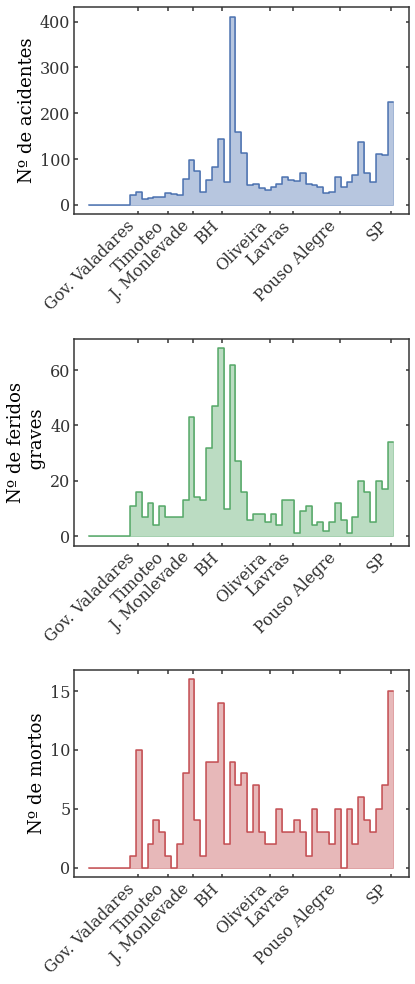

In [18]:
x = np.arange(data.iloc[-1, 0] + 2)
y = np.zeros((data.iloc[-1, 0] + 1, 4))
y[data.loc[:, "Nkm"].values, 0] = data.loc[:, "sum(feridos_leves)"].values
y[data.loc[:, "Nkm"].values, 1] = data.loc[:, "sum(feridos_graves)"].values
y[data.loc[:, "Nkm"].values, 2] = data.loc[:, "sum(mortos)"].values
y[data.loc[:, "Nkm"].values, 3] = data.loc[:, "count(id)"].values
y = np.append(y, y[-1:, :], axis=0)

fig, ax = plt.subplots(3, 1, figsize=(6, 16))
ax[0].step(step*x, y[:, 3], where="post", color="C0")
ax[0].fill_between(step*x, y[:, 3], step="post", alpha=0.4, color="C0")

ax[1].step(step*x, y[:, 1], where="post", color="C1")
ax[1].fill_between(step*x, y[:, 1], step="post", alpha=0.4, color="C1")

ax[2].step(step*x, y[:, 2], where="post", color="C2")
ax[2].fill_between(step*x, y[:, 2], step="post", alpha=0.4, color="C2")

labels = ["Nº de acidentes", "Nº de feridos\n graves", "Nº de mortos"]
for i, axi in enumerate(ax): 
    axi.set_ylabel(labels[i])
    axi.set_xticks(xticks)
    axi.set_xticklabels(municipios_abrev, rotation = 45, ha="right")

fig.subplots_adjust(hspace=0.6)

print("Total de %d acidentes na BR-381 em 2020." % np.sum(y[:, 3]))
print("Total de %d feridos graves e %d mortos na BR-381 em 2020." 
      % (np.sum(y[:, 1]), np.sum(y[:, 2])))

### Voltando aos dados em todo o país, qual meio de transporte tem mais mortes nas estradas?

In [19]:
# Read another csv file.
df = (spark.read.format("csv")
      .options(header="True", sep=';', encoding="ISO-8859-1", infer_schema="True")
      .load("acidentes2020.csv"))

for tag in ["km", "latitude", "longitude"]:
    df = df.withColumn(tag, F.regexp_replace(tag, ',', '.'))
    df = df.withColumn(tag, df[tag].cast("float"))
    
for tag in ["idade", "ilesos", "feridos_leves", "feridos_graves", "mortos"]:
    df = df.withColumn(tag, df[tag].cast("int"))

In [20]:
# Group by 'tipo_veiculo'. 
# For now we are interested only in the people inside the vehicles.
df_tipo = (df.select("tipo_veiculo", "tipo_envolvido", "mortos", "feridos_graves")
           .where((df.tipo_envolvido == "Passageiro") | (df.tipo_envolvido == "Condutor"))
           .groupBy("tipo_veiculo")
           .agg(F.sum("feridos_graves"), F.sum("mortos"))
           .sort(F.col("sum(mortos)").desc()))

# Rename columns.
df_tipo = (df_tipo.withColumnRenamed("sum(mortos)", "mortos")
           .withColumnRenamed("sum(feridos_graves)", "feridos_graves"))

# Convert to pandas.
df_tipo = df_tipo.toPandas().set_index("tipo_veiculo")
df_tipo.iloc[0:10, :]

,feridos_graves,mortos
tipo_veiculo,,
Automóvel,4886,1572
Motocicleta,6719,1482
Caminhão,688,312
Caminhonete,923,281
Caminhão-trator,658,275
Bicicleta,607,233
Motoneta,655,99
Camioneta,223,63
Ônibus,174,49


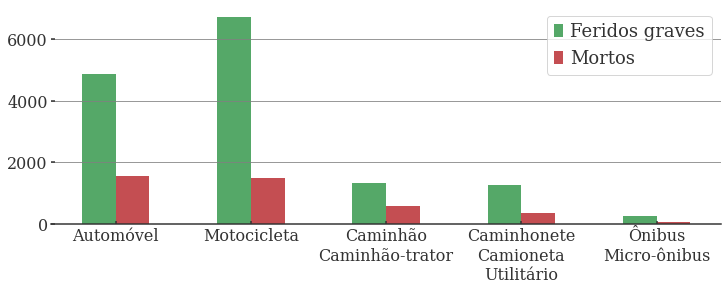

In [21]:
x = np.arange(5)
width = 0.25
y = np.zeros((5, 2))
y[0, :] = df_tipo.loc["Automóvel", :]
y[1, :] = df_tipo.loc["Motocicleta", :] 
y[2, :] = df_tipo.loc["Caminhão", :] + df_tipo.loc["Caminhão-trator", :]
y[3, :] = (df_tipo.loc["Caminhonete", :] + df_tipo.loc["Camioneta", :]
           + df_tipo.loc["Utilitário", :])
y[4, :] = df_tipo.loc["Ônibus", :] + df_tipo.loc["Micro-ônibus", :] 

fig, ax = plt.subplots(figsize=(12,4))
rects1 = ax.bar(x - width/2, y[:, 0], width, label='Feridos graves', color="C1")
rects2 = ax.bar(x + width/2, y[:, 1], width, label='Mortos', color="C2")

ax.legend()
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xticks(x)
ax.set_xticklabels(["Automóvel", "Motocicleta", "Caminhão\nCaminhão-trator", 
                   "Caminhonete\nCamioneta\nUtilitário", "Ônibus\nMicro-ônibus"])

for tag in ["right", "left", "top"]:
    ax.spines[tag].set_visible(False)

ax.grid(axis="y")

### Qual a maior causa de mortes nas estradas?

In [22]:
# Group by 'causa_acidente'.
df_causa = (df.select("causa_acidente", "feridos_graves", "mortos")
            .groupBy("causa_acidente")
            .agg(F.sum("feridos_graves"),
                 F.sum("mortos"))
            .sort(F.col("sum(mortos)").desc()))

# Rename columns.
df_causa = (df_causa.withColumnRenamed("sum(mortos)", "mortos")
            .withColumnRenamed("sum(feridos_graves)", "feridos_graves"))

# Convert to pandas.
df_causa = df_causa.toPandas()
df_causa.iloc[0:10, :]

,causa_acidente,feridos_graves,mortos
0,Falta de Atenção à Condução,5650,1246
1,Desobediência às normas de trânsito pelo condutor,3060,893
2,Velocidade Incompatível,1775,712
3,Falta de Atenção do Pedestre,684,528
4,Ingestão de Álcool,1162,336
5,Ultrapassagem Indevida,619,318
6,Condutor Dormindo,629,251
7,Defeito Mecânico no Veículo,561,138
8,Desobediência às normas de trânsito pelo pedestre,140,129
9,Pista Escorregadia,393,106


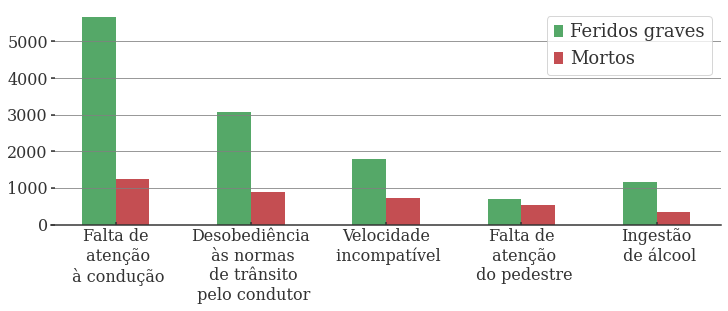

In [23]:
x = np.arange(5)
width = 0.25
y = df_causa.iloc[0:5, :].values

fig, ax = plt.subplots(figsize=(12,4))
rects1 = ax.bar(x - width/2, y[:, 1], width, label='Feridos graves', color="C1")
rects2 = ax.bar(x + width/2, y[:, 2], width, label='Mortos', color="C2")

ax.legend()
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xticks(x)
ax.set_xticklabels(['Falta de\n atenção\n à condução',
                    'Desobediência\n às normas\n de trânsito\n pelo condutor',
                    'Velocidade\n incompatível', 
                    'Falta de\n atenção\n do pedestre',
                    'Ingestão\n de álcool'])

for tag in ["right", "left", "top"]:
    ax.spines[tag].set_visible(False)

ax.grid(axis="y")

In [24]:
#data = pd.read_csv('datatran2020.csv', sep=';', encoding='latin-1', decimal=',')